 <img src="https://www.mathnasium.com/storage/app/media/uploaded-files/Tessellation%20-%20Regular%20Tessellations.jpg" />

### Using Uber H3 mosaic using Python

In [ ]:
! pip install geopandas
! pip install matplotlib
! pip install jupyter ipykernel
! pip install pyarrow
! pip install h3
! pip install foliumimport geopandas as gpd
! pip install haversine

In [1]:
import h3
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [41]:
print(h3.__version__)

4.3.0


#### Example 1: Generating H3 mosaic showing some Census 2022 data.

Data source: https://censo2022.ibge.gov.br/apps/pgi/#/home/, População, População residente - Municípios 2022

In [43]:
INPUT_FILE = r".\data\PopResid_munic_Censo22.zip"

In [39]:
# Funcion library

def auto_select_resolution(gdf):
    """Automatically select H3 resolution based on data density
For reference, here are typical H3 hexagon sizes:
Resolution 1: Average hexagon area of 607,220.9782429 km²,
Resolution 2: Average hexagon area of 86,745.8540347 km².
Resolution 3: Average hexagon area of 12,392.2648621 km².
Resolution 4: Average hexagon area of 1,770.3235517 km².
Resolution 5: Average hexagon area of 252.9 km².
Resolution 6: Average hexagon area of 36.1 km².
Resolution 7: Average hexagon area of 5.15 km².
Resolution 8: Average hexagon area of 0.736 km².
Resolution 9: Average hexagon area of 0.105 km².
Resolution 10: Average hexagon area of 0.015 km².
Resolution 11: Average hexagon area of 0.0023 km²,
Resolution 12: Average hexagon area of 0.0003 km².
Resolution 13: Average hexagon area of 0.00004 km².
Resolution 14: Average hexagon area of 0.000006 km².
Resolution 15: Very small hexagons, with an average area of 0.895 m²
    """
    bounds = gdf.total_bounds
    area = (bounds[2] - bounds[0]) * (bounds[3] - bounds[1])
    point_count = len(gdf)

    if point_count < 1000:
        return 6
    elif point_count < 10000:
        return 7
    elif point_count < 100000:
        return 8
    else:
        return 9

def points_to_hexagons(gdf_points, resolution):
    """Convert points to H3 hexagons with proper coordinate handling"""
    # Add H3 index to each point (lat, lng order)
    gdf_points['hex_id'] = gdf_points.apply(
        lambda row: h3.latlng_to_cell(row.geometry.y, row.geometry.x, resolution),
        axis=1
    )

    # Aggregate data by hexagon
    def join_names(series):
        """Convert series to comma-separated string without duplicates"""
        unique_names = list(set(series.dropna().astype(str)))
        return ", ".join(unique_names)

    hex_agg = gdf_points.groupby('hex_id').agg({
        'PopResid': 'sum',
        'Nome': join_names
    }).reset_index()

    # Create hexagon geometries
    hex_data = []
    for hex_id in hex_agg['hex_id']:
        # Get hexagon boundary (returns list of (lat, lng) tuples)
        hex_boundary = h3.cell_to_boundary(hex_id)

        # Convert to (lng, lat) order for GeoPandas
        hex_coords = [(lng, lat) for lat, lng in hex_boundary]
        polygon = Polygon(hex_coords)

        hex_data.append({
            'hex_id': hex_id,
            'geometry': polygon,
            'PopResid': hex_agg[hex_agg['hex_id'] == hex_id]['PopResid'].values[0],
            'Nomes': hex_agg[hex_agg['hex_id'] == hex_id]['Nome'].values[0]
        })

    return gpd.GeoDataFrame(hex_data, crs="EPSG:4326")

def convert_multipoint_to_point(geom):
    """Convert MULTIPOINT to POINT geometry"""
    if geom.geom_type == 'MultiPoint':
        return next(iter(geom.geoms))
    return geom

In [44]:
gdf_points = gpd.read_file(INPUT_FILE)
gdf_points['geometry'] = gdf_points['geometry'].apply(convert_multipoint_to_point) # Convert MULTIPOINT to POINT
gdf_points.to_crs(4326, inplace=True)
#gdf_points.dtypes
gdf_points.head()

,Geocodigo,Nome,AreaUnidTe,DensDemog,PopResid,geometry
0,1100015,Alta Floresta D'Oeste - RO,7067.127,3.04,21494.0,POINT (-62.00369 -11.933)
1,1100023,Ariquemes - RO,4426.571,21.88,96833.0,POINT (-63.03381 -9.91197)
2,1100031,Cabixi - RO,1314.352,4.07,5351.0,POINT (-60.5429 -13.4945)
3,1100049,Cacoal - RO,3793.000,22.91,86887.0,POINT (-61.4512 -11.4356)
4,1100056,Cerejeiras - RO,2783.300,5.71,15890.0,POINT (-60.81169 -13.18636)


In [36]:
#resolution = auto_select_resolution(gdf_points)
resolution = 4
print(f"Using H3 resolution: {resolution}")
hex_gdf = points_to_hexagons(gdf_points, resolution)
hex_gdf['name_count'] = hex_gdf['Nomes'].apply(lambda x: len(x.split(", ")) if x else 0)
hex_gdf.head()

Using H3 resolution: 4


,hex_id,geometry,PopResid,Nomes,name_count
0,845f161ffffffff,"POLYGON ((-51.87148 3.57396, -51.67846 3.7354,...",27482.0,Oiapoque - AP,1
1,845f291ffffffff,"POLYGON ((-59.51961 3.60706, -59.33704 3.76491...",13986.0,Normandia - RR,1
2,845f299ffffffff,"POLYGON ((-59.66815 3.21249, -59.48574 3.37016...",13923.0,Bonfim - RR,1
3,845f745ffffffff,"POLYGON ((-60.018 4.2354, -59.8365 4.39303, -5...",13751.0,Uiramutã - RR,1
4,845f75dffffffff,"POLYGON ((-61.05214 4.38642, -60.87262 4.54337...",19305.0,Pacaraima - RR,1


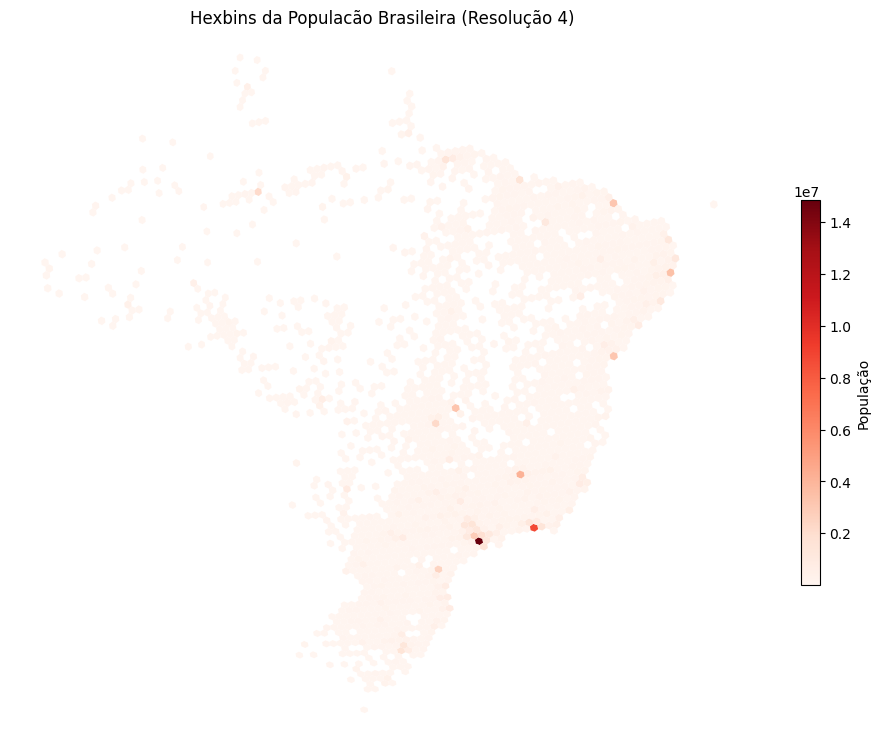

In [46]:
# 1. First ensure you have the proper backend for matplotlib
%matplotlib inline

# Main execution
# Load and prepare data
gdf_points = gpd.read_file(INPUT_FILE)
gdf_points['geometry'] = gdf_points['geometry'].apply(convert_multipoint_to_point)
gdf_points = gdf_points.to_crs(epsg=4326)

hex_gdf = points_to_hexagons(gdf_points, resolution)
hex_gdf['name_count'] = hex_gdf['Nomes'].apply(lambda x: len(x.split(", ")) if x else 0)

#hex_gdf = hex_gdf[hex_gdf['Nomes'] != "São Paulo - SP"]
#hex_gdf = hex_gdf[~hex_gdf['Nomes'].str.endswith("- SP")]

# Create figure with adjusted settings
fig, ax = plt.subplots(figsize=(12, 10))

# Plot with explicit zorder and alpha values
hex_gdf.plot(
    ax=ax,
    column='PopResid',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': "População", 'shrink': 0.5},
    edgecolor='k',
    linewidth=0.0,
    alpha=1,
    zorder=2
)

# Set Brazil bounds and add title
ax.set_xlim(-75, -30)
ax.set_ylim(-35, 5)
ax.set_title(f"Hexbins da Populacão Brasileira (Resolução {resolution})", pad=20)

# Turn off the axis lines and ticks
ax.set_axis_off()

# Add a background color (helps visibility)
ax.set_facecolor('#f0f0f0')

# Force display in Jupyter
display(fig)

# Close the figure to prevent duplicate displays
plt.close(fig)

# Save output
#hex_gdf.to_file(r"output\AdaptaHexagonalTest.shp")
hex_gdf.to_file(rf"output\AdaptaHexagonalTestResolution{resolution}.geojson")

#### Example 2: Generating H3 mosaic covering Brazil area.

Data source: https://censo2022.ibge.gov.br/apps/pgi/#/home/, População, População residente - Municípios 2022